In [1]:
import pandas as pd
import numpy as np
from numpy import mean

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

from matplotlib import pyplot as plt

#import warnings

#warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preprocessing

In [3]:
data.drop(index = data[data['gender']=='Other'].index[0] ,axis=0,inplace=True)

data.replace(to_replace="Urban", value=1, inplace=True)
data.replace(to_replace="Rural", value=0, inplace=True)

data.replace(to_replace="Yes", value=1, inplace=True)
data.replace(to_replace="No", value=0, inplace=True)

In [4]:
#description of percent of data object columns
col = data.select_dtypes(include=['object']).columns.tolist()
#create iteration of object columns
for i in col:
    count = data.groupby(['stroke'])[i].value_counts()[1]
    percent = data.groupby(['stroke'])[i].value_counts(normalize=True)[1]
    display(pd.DataFrame({"Patients":count, "Percent":percent*100})\
            .sort_values("Percent", ascending=False)
            .style.set_caption('Variable: {}'.format(i))\
            .format({"Percent": "{:,.1f}%"})
            .highlight_max(props='font-weight:bold; color:Black', axis=0)) 

,Patients,Percent
gender,,
Female,141,56.6%
Male,108,43.4%


,Patients,Percent
work_type,,
Private,149,59.8%
Self-employed,65,26.1%
Govt_job,33,13.3%
children,2,0.8%


,Patients,Percent
smoking_status,,
never smoked,90,36.1%
formerly smoked,70,28.1%
Unknown,47,18.9%
smokes,42,16.9%


In [5]:
data = pd.get_dummies(data, columns=['work_type', 'smoking_status', 'gender'])
data.drop(columns=['id'], inplace=True)
data = data.dropna()
data.head()

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male
0,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0,0,1
2,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0,0,1
3,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1,1,0
4,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0,1,0
5,81.0,0,0,1,1,186.21,29.0,1,0,0,1,0,0,0,1,0,0,0,1


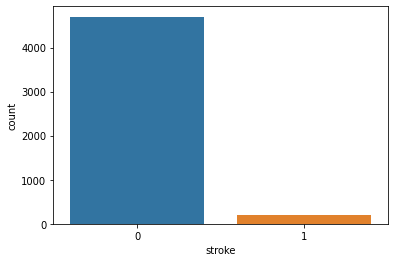

In [6]:
sns.countplot(data=data,x='stroke')
plt.show()

In [7]:
yData = data.pop('stroke').to_numpy()
xData = data.to_numpy()

xData = xData.astype(np.float32)
yData = yData.astype(np.float32)

xData.shape, yData.shape

((4908, 18), (4908,))

In [8]:
# Split data into train and test
train_x, test_x, train_y, test_y = train_test_split(xData, yData, test_size=0.2, shuffle=True)

In [9]:
# # sensitivity analysis of k in k-fold cross-validation
 
# # evaluate the model using a given test condition
# def evaluate_model(cv):
#     model = DecisionTreeClassifier()
#     scores = cross_val_score(model, train_x, train_y, scoring='accuracy', cv=cv, n_jobs=-1)
#     # return scores
#     return mean(scores), scores.min(), scores.max()
 
# # calculate the ideal test condition
# ideal, _, _ = evaluate_model(LeaveOneOut())
# print('Ideal: %.3f' % ideal)
# # define folds to test
# folds = range(2,31)
# # record mean and min/max of each set of results
# means, mins, maxs = list(),list(),list()
# # evaluate each k value
# for k in folds:
#     # define the test condition
#     cv = KFold(n_splits=k, shuffle=True, random_state=1)
#     # evaluate k value
#     k_mean, k_min, k_max = evaluate_model(cv)
#     # report performance
#     print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
#     # store mean accuracy
#     means.append(k_mean)
#     # store min and max relative to the mean
#     mins.append(k_mean - k_min)
#     maxs.append(k_max - k_mean)
# # line plot of k mean values with min/max error bars
# pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# # plot the ideal case in a separate color
# pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# # show the plot
# pyplot.show()

In [10]:
#kf = KFold(n_splits=10, shuffle=True)

In [11]:
# Create a function to save results
import json

def save_results(results, filename):
    with open(filename + '.json', 'w') as fp:
        json.dump(results, fp)
        
        
def load_results(file_name):
    with open(file_name) as f:
        temp_results = json.load(f)
    return temp_results

# Decision Trees
Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems. It is a tree-structured classifier, where internal nodes represent the features of a dataset, branches represent the decision rules and each leaf node represents the outcome.

In a Decision tree, there are two nodes, which are the Decision Node and Leaf Node. Decision nodes are used to make any decision and have multiple branches, whereas Leaf nodes are the output of those decisions and do not contain any further branches.

In [166]:
### Evaluate model without any pruning
# Train model
model = DecisionTreeClassifier()
model = model.fit(train_x, train_y)

# Evaluate performance
train_accuracy = model.score(train_x, train_y)
test_accuracy = model.score(test_x, test_y)

print('Training accuracy: ' + str(train_accuracy))
print('Test accuracy: ' + str(test_accuracy))

Training accuracy: 1.0
Test accuracy: 0.9124236252545825


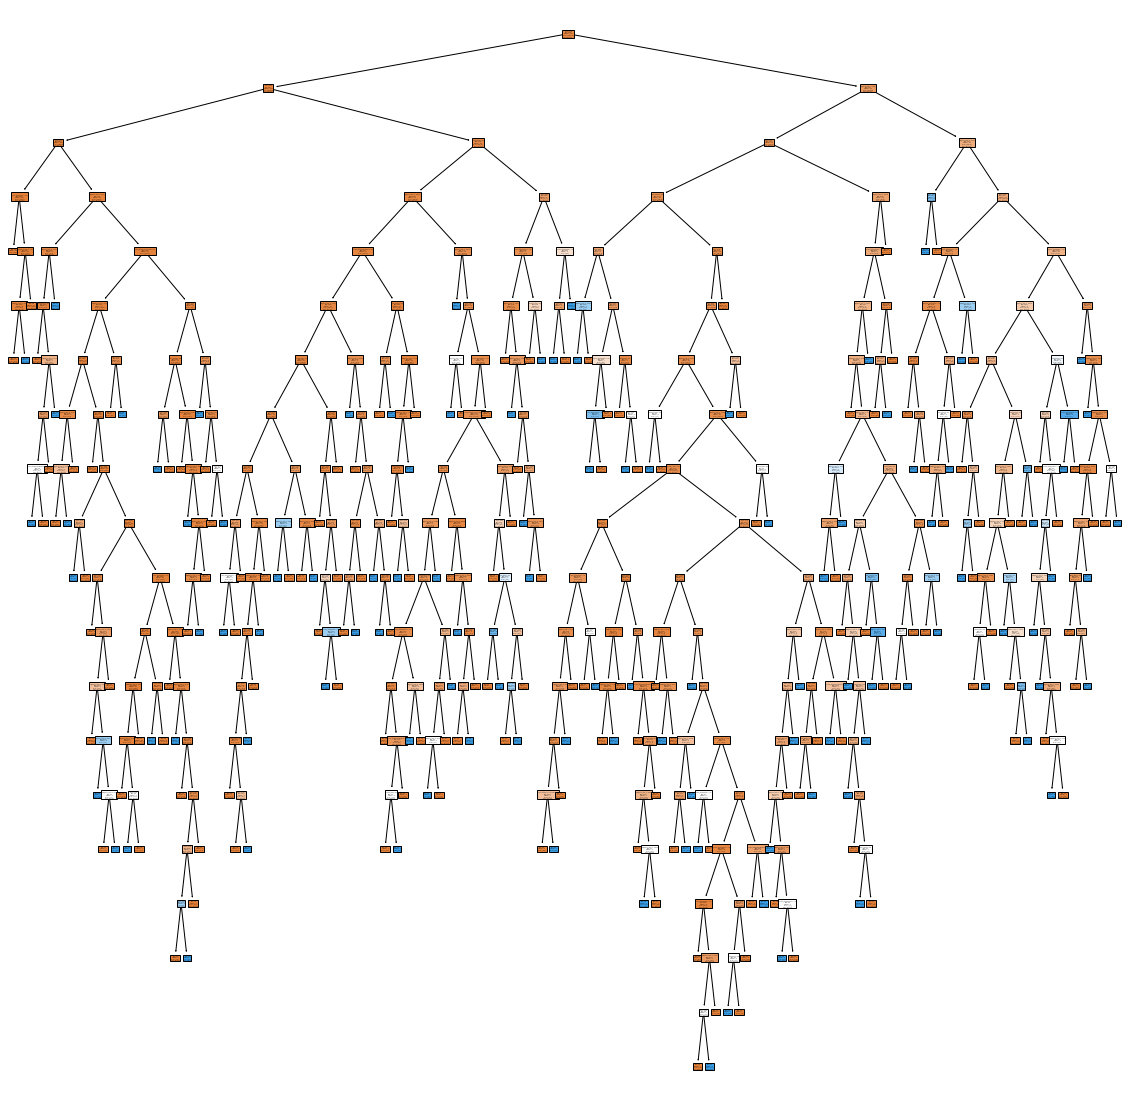

In [167]:
# visualiza the tree
from sklearn import tree
plt.figure(figsize=(20,20))
features = data.columns
classes = ['No stroke','stroke']
tree.plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

In [168]:
# Initialize model
model = DecisionTreeClassifier()

# Compute path for pruning
path = model.cost_complexity_pruning_path(train_x, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

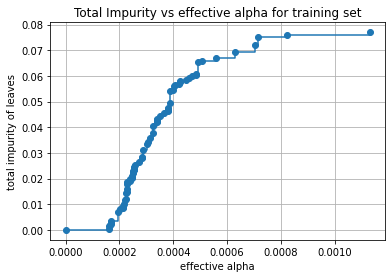

In [169]:
# the maximum effective alpha value is removed, because it is the trivial tree with only one node.
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
plt.grid()
ax.set_title("Total Impurity vs effective alpha for training set")

In [170]:
# we train a decision tree using the effective alphas. 
# The last value in ccp_alphas is the alpha value that prunes the whole tree, 
# leaving the tree, clfs[-1], with one node.
# For each alpha we will append our model to a list

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_x, train_y)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.005348379494966346


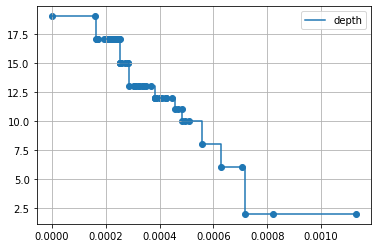

In [171]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
#plt.set_xlabel("alpha")
#plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
#plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.grid()
plt.legend()
plt.show()


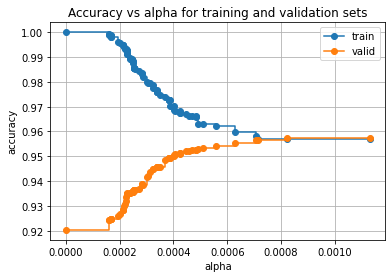

In [172]:
train_scores = [clf.score(train_x, train_y) for clf in clfs]
test_scores = [clf.score(test_x, test_y) for clf in clfs]
cv_scores = [cross_val_score(clf, xData, yData, cv=10).mean() for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, cv_scores, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

In [173]:
max_index = np.argmax(cv_scores)
print("max index:", max_index)
print('Optimized alpha: ' + str(ccp_alphas[max_index]))
print('Training accuracy: ' + str(round(train_scores[max_index]*100, 2)) + '%')
print('Test accuracy: ' + str(round(cv_scores[max_index]*100, 2)) + '%')

max index: 72
Optimized alpha: 0.0008219474913443783
Training accuracy: 95.7%
Test accuracy: 95.74%


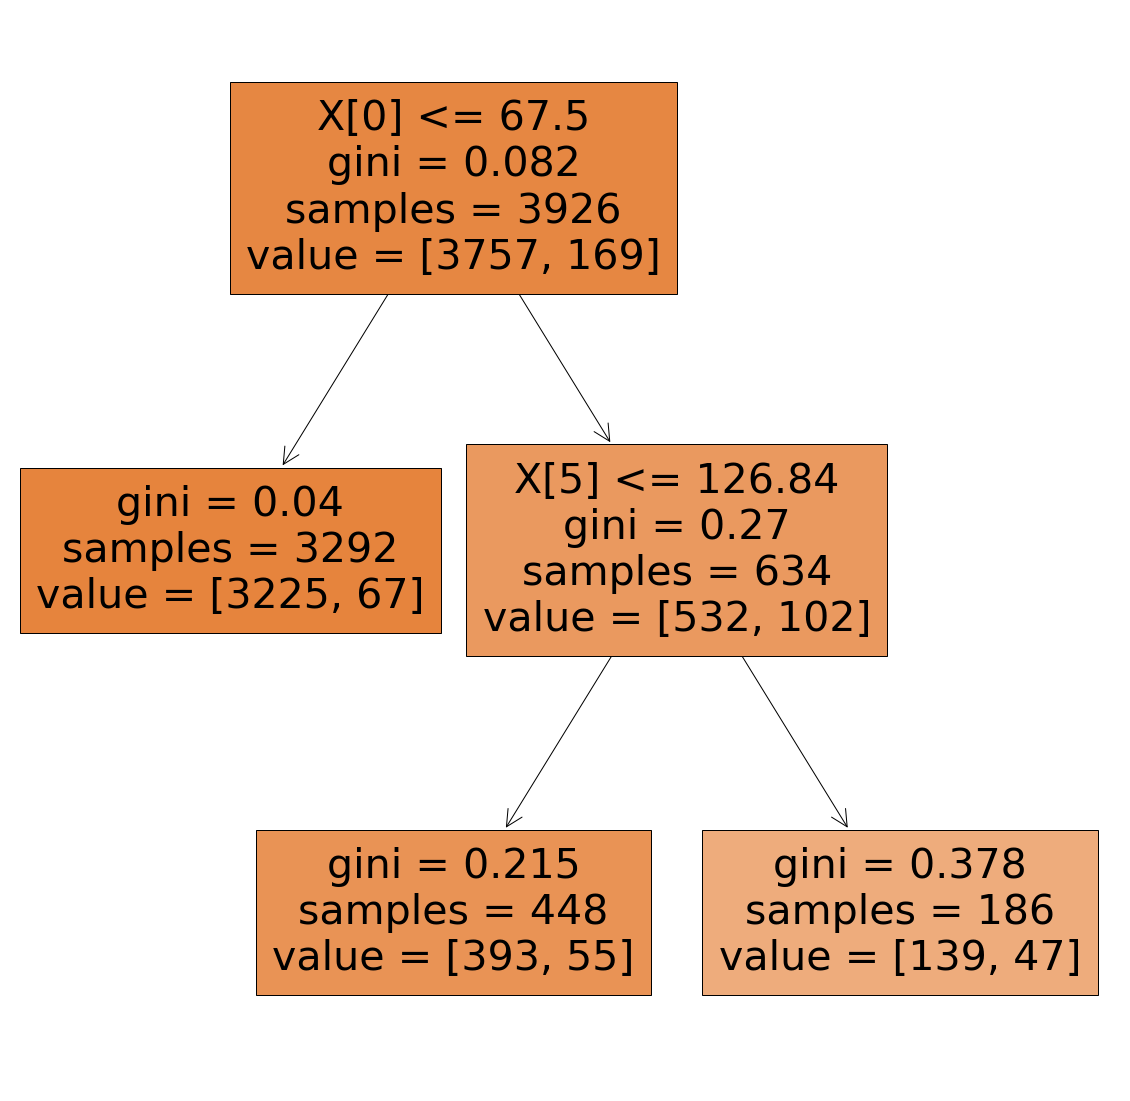

In [174]:
from sklearn import tree
tree_clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[max_index])
plt.figure(figsize=(20,20))
tree_clf.fit(train_x, train_y)
tree.plot_tree(tree_clf,filled=True)
plt.show()

/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



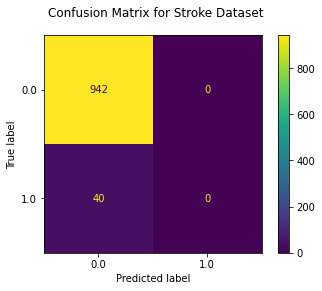

In [175]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(tree_clf, test_x, test_y, display_labels=tree_clf.classes_)
fig.figure_.suptitle("Confusion Matrix for Stroke Dataset")
plt.show()

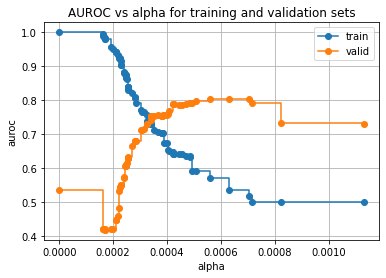

In [176]:
from sklearn.metrics import roc_auc_score

train_auroc = [roc_auc_score(train_y, clf.predict(train_x), average=None) for clf in clfs]
cv_auroc = [cross_val_score(clf, xData, yData, scoring="roc_auc", cv=10).mean() for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("auroc")
ax.set_title("AUROC vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_auroc, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, cv_auroc, marker="o", label="valid", drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()


In [177]:
max_index_auroc = np.argmax(cv_auroc)
print(max_index_auroc)
print('Optimized alpha: ' + str(ccp_alphas[max_index_auroc]))
print('Training accuracy: ' + str(round(train_scores[max_index_auroc]*100, 5)) + '%')
print('Test accuracy: ' + str(round(test_scores[max_index_auroc]*100,5)) + '%')

68
Optimized alpha: 0.0005591661220800291
Training accuracy: 96.23026%
Test accuracy: 95.21385%


0.009286880493164062


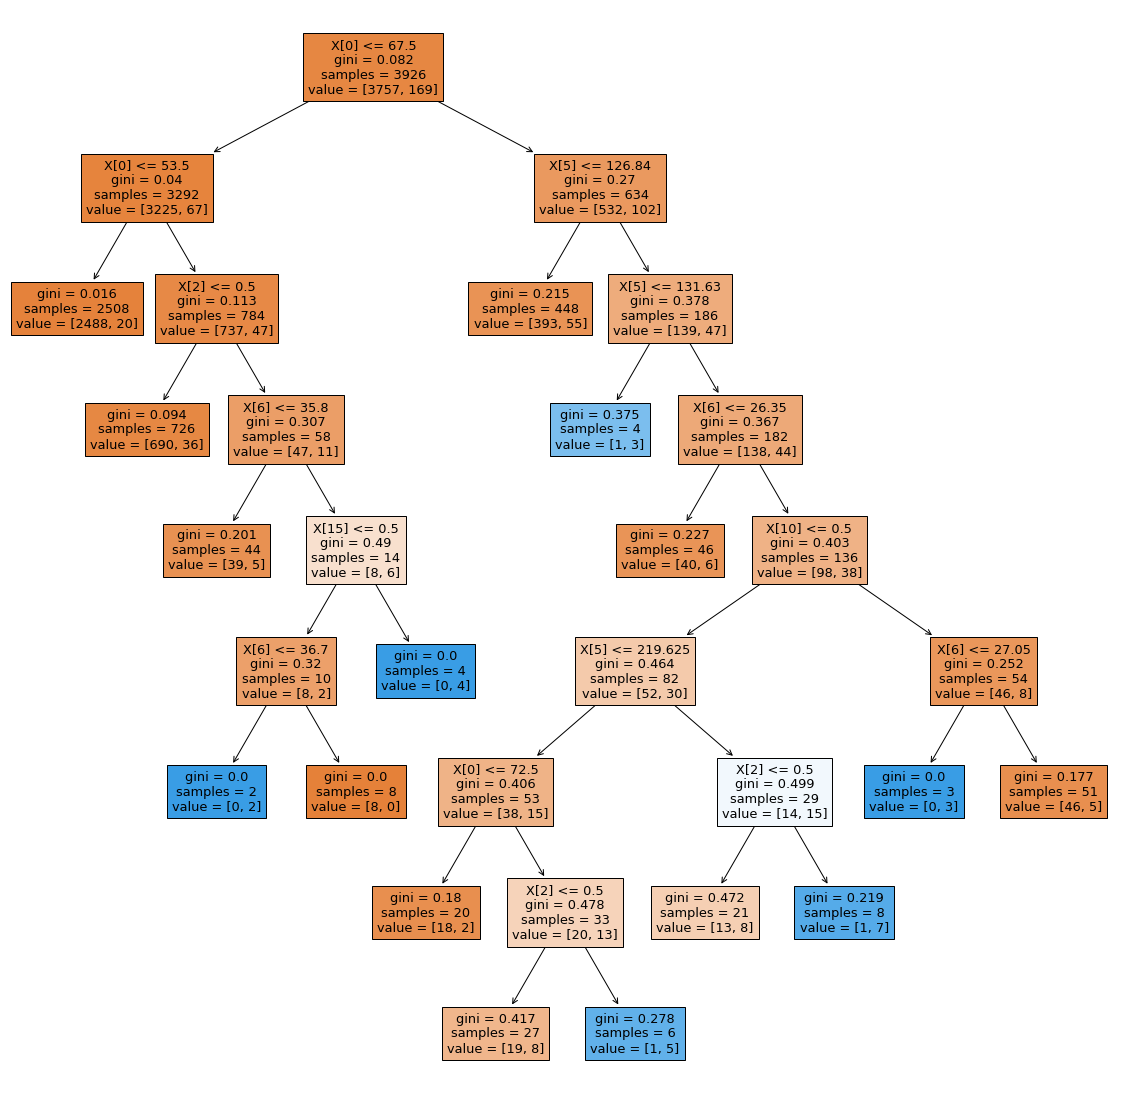

In [178]:
import time
s = time.time()
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[max_index_auroc])
clf.fit(train_x, train_y)
e = time.time()
print(e-s)

plt.figure(figsize=(20,20))
tree.plot_tree(clf,filled=True)
plt.show()

In [81]:
clf

DecisionTreeClassifier(ccp_alpha=0.0005254186860275643, random_state=0)

/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



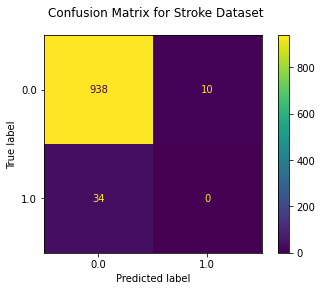

In [82]:
fig = plot_confusion_matrix(clf, test_x, test_y, display_labels=clf.classes_)
fig.figure_.suptitle("Confusion Matrix for Stroke Dataset")
plt.show()

# Neural Networks

In [133]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [134]:
# To train a MLP network, the data should always be scaled because it is very sensitive to it.
sc=StandardScaler()

scaler = sc.fit(train_x)
trainX_scaled = scaler.transform(train_x)
testX_scaled = scaler.transform(test_x)

In [160]:
### Create a function to fit and evaluate DT at given alphas
def evaluate_nn(train_x, train_y, test_x, test_y, hyperparameter_dic, resutls_nn):
    
    layers = hyperparameter_dic['layers']
    sizes = hyperparameter_dic['sizes']
    alphas = hyperparameter_dic['alphas']
    
    number_models = len(layers)*len(sizes)*len(alphas)
    i = len(list(resutls_nn.keys()))
    
    for number_layers in layers:
        for layer_size in sizes:
            for alpha in alphas:

                for r_i in list(results_nn.keys()):
                    if alpha == results_nn[r_i][0]:
                        if layer_size == results_nn[r_i][4]:
                            if number_layers == results_nn[r_i][3]:
                                continue

                print('Training model {} of {}...'.format(i+1, number_models))

                # Initialize model
                mlp_clf = MLPClassifier(
                    hidden_layer_sizes = [layer_size]*number_layers,
                    alpha = alpha,
                    max_iter = 1500,
                    learning_rate = 'invscaling',
                    #early_stopping = True,
                    verbose = True
                )

                # Fit model
                mlp_clf.fit(train_x, train_y)

                # Evaluate performance
                train_accuracy = mlp_clf.score(train_x, train_y)
                test_accuracy = mlp_clf.score(test_x, test_y)

                # Save resutls_nn
                resutls_nn[i] = (number_layers, layer_size, alpha, train_accuracy, test_accuracy)

                # Update i
                i += 1

    return resutls_nn

In [161]:
layers = [1, 2]
sizes = [8, 16, 32, 64]
alphas = [0.0001, 0.001, 0.01] # Strength of the L2 regularization term

hyperparameters_dic = {
    'layers': layers,
    'sizes': sizes,
    'alphas': alphas
}

results_nn = {}

results_nn = evaluate_nn(trainX_scaled, train_y, testX_scaled, test_y, hyperparameters_dic, results_nn)

Training model 1 of 24...
Iteration 1, loss = 0.77214902
Iteration 2, loss = 0.64714387
Iteration 3, loss = 0.54955364
Iteration 4, loss = 0.47438642
Iteration 5, loss = 0.41588684
Iteration 6, loss = 0.37083661
Iteration 7, loss = 0.33487596
Iteration 8, loss = 0.30647030
Iteration 9, loss = 0.28319570
Iteration 10, loss = 0.26451371
Iteration 11, loss = 0.24898341
Iteration 12, loss = 0.23621662
Iteration 13, loss = 0.22555293
Iteration 14, loss = 0.21653106
Iteration 15, loss = 0.20888991
Iteration 16, loss = 0.20231833
Iteration 17, loss = 0.19657409
Iteration 18, loss = 0.19175125
Iteration 19, loss = 0.18742532
Iteration 20, loss = 0.18376487
Iteration 21, loss = 0.18054204
Iteration 22, loss = 0.17757999
Iteration 23, loss = 0.17507257
Iteration 24, loss = 0.17267004
Iteration 25, loss = 0.17066418
Iteration 26, loss = 0.16877881
Iteration 27, loss = 0.16704669
Iteration 28, loss = 0.16549562
Iteration 29, loss = 0.16407826
Iteration 30, loss = 0.16271263
Iteration 31, loss = 0.

Iteration 56, loss = 0.13860963
Iteration 57, loss = 0.13846302
Iteration 58, loss = 0.13836761
Iteration 59, loss = 0.13812679
Iteration 60, loss = 0.13798578
Iteration 61, loss = 0.13787520
Iteration 62, loss = 0.13779765
Iteration 63, loss = 0.13760286
Iteration 64, loss = 0.13748521
Iteration 65, loss = 0.13739384
Iteration 66, loss = 0.13719636
Iteration 67, loss = 0.13711801
Iteration 68, loss = 0.13701293
Iteration 69, loss = 0.13685381
Iteration 70, loss = 0.13673864
Iteration 71, loss = 0.13664340
Iteration 72, loss = 0.13653816
Iteration 73, loss = 0.13645643
Iteration 74, loss = 0.13635645
Iteration 75, loss = 0.13626964
Iteration 76, loss = 0.13609067
Iteration 77, loss = 0.13601861
Iteration 78, loss = 0.13589773
Iteration 79, loss = 0.13581867
Iteration 80, loss = 0.13576251
Iteration 81, loss = 0.13559329
Iteration 82, loss = 0.13545149
Iteration 83, loss = 0.13541807
Iteration 84, loss = 0.13537703
Iteration 85, loss = 0.13519910
Iteration 86, loss = 0.13509839
Iteratio

Iteration 95, loss = 0.13320188
Iteration 96, loss = 0.13297397
Iteration 97, loss = 0.13288269
Iteration 98, loss = 0.13285920
Iteration 99, loss = 0.13261454
Iteration 100, loss = 0.13253721
Iteration 101, loss = 0.13248586
Iteration 102, loss = 0.13232016
Iteration 103, loss = 0.13219113
Iteration 104, loss = 0.13211677
Iteration 105, loss = 0.13202408
Iteration 106, loss = 0.13191233
Iteration 107, loss = 0.13188901
Iteration 108, loss = 0.13173999
Iteration 109, loss = 0.13178497
Iteration 110, loss = 0.13153789
Iteration 111, loss = 0.13151896
Iteration 112, loss = 0.13142163
Iteration 113, loss = 0.13129592
Iteration 114, loss = 0.13120734
Iteration 115, loss = 0.13115043
Iteration 116, loss = 0.13106937
Iteration 117, loss = 0.13102111
Iteration 118, loss = 0.13087333
Iteration 119, loss = 0.13084200
Iteration 120, loss = 0.13076483
Iteration 121, loss = 0.13069083
Iteration 122, loss = 0.13057900
Iteration 123, loss = 0.13038992
Iteration 124, loss = 0.13041482
Iteration 125, 

Iteration 52, loss = 0.14569691
Iteration 53, loss = 0.14541888
Iteration 54, loss = 0.14504313
Iteration 55, loss = 0.14468483
Iteration 56, loss = 0.14436886
Iteration 57, loss = 0.14408145
Iteration 58, loss = 0.14377313
Iteration 59, loss = 0.14353890
Iteration 60, loss = 0.14325368
Iteration 61, loss = 0.14299855
Iteration 62, loss = 0.14273632
Iteration 63, loss = 0.14245748
Iteration 64, loss = 0.14222525
Iteration 65, loss = 0.14199242
Iteration 66, loss = 0.14176958
Iteration 67, loss = 0.14159450
Iteration 68, loss = 0.14140465
Iteration 69, loss = 0.14113206
Iteration 70, loss = 0.14094462
Iteration 71, loss = 0.14072336
Iteration 72, loss = 0.14060719
Iteration 73, loss = 0.14040981
Iteration 74, loss = 0.14020196
Iteration 75, loss = 0.14000425
Iteration 76, loss = 0.13976878
Iteration 77, loss = 0.13967745
Iteration 78, loss = 0.13944717
Iteration 79, loss = 0.13938615
Iteration 80, loss = 0.13920052
Iteration 81, loss = 0.13900938
Iteration 82, loss = 0.13879949
Iteratio

Iteration 126, loss = 0.12744438
Iteration 127, loss = 0.12738499
Iteration 128, loss = 0.12739487
Iteration 129, loss = 0.12722907
Iteration 130, loss = 0.12716029
Iteration 131, loss = 0.12715157
Iteration 132, loss = 0.12702109
Iteration 133, loss = 0.12699506
Iteration 134, loss = 0.12695416
Iteration 135, loss = 0.12686640
Iteration 136, loss = 0.12688107
Iteration 137, loss = 0.12685723
Iteration 138, loss = 0.12668543
Iteration 139, loss = 0.12659438
Iteration 140, loss = 0.12658103
Iteration 141, loss = 0.12659172
Iteration 142, loss = 0.12652823
Iteration 143, loss = 0.12649417
Iteration 144, loss = 0.12638590
Iteration 145, loss = 0.12630417
Iteration 146, loss = 0.12619393
Iteration 147, loss = 0.12624488
Iteration 148, loss = 0.12620686
Iteration 149, loss = 0.12618484
Iteration 150, loss = 0.12615883
Iteration 151, loss = 0.12607030
Iteration 152, loss = 0.12604679
Iteration 153, loss = 0.12601184
Iteration 154, loss = 0.12590227
Iteration 155, loss = 0.12585505
Iteration 

Iteration 212, loss = 0.11785689
Iteration 213, loss = 0.11787642
Iteration 214, loss = 0.11792209
Iteration 215, loss = 0.11781574
Iteration 216, loss = 0.11751664
Iteration 217, loss = 0.11764707
Iteration 218, loss = 0.11754394
Iteration 219, loss = 0.11749696
Iteration 220, loss = 0.11757962
Iteration 221, loss = 0.11741479
Iteration 222, loss = 0.11746171
Iteration 223, loss = 0.11744959
Iteration 224, loss = 0.11714891
Iteration 225, loss = 0.11719381
Iteration 226, loss = 0.11711016
Iteration 227, loss = 0.11740205
Iteration 228, loss = 0.11706622
Iteration 229, loss = 0.11710649
Iteration 230, loss = 0.11698276
Iteration 231, loss = 0.11713799
Iteration 232, loss = 0.11689043
Iteration 233, loss = 0.11689547
Iteration 234, loss = 0.11690511
Iteration 235, loss = 0.11696361
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 8 of 24...
Iteration 1, loss = 0.79271353
Iteration 2, loss = 0.58606500
Iteration 3, loss = 0.44691984

Iteration 236, loss = 0.11607619
Iteration 237, loss = 0.11583495
Iteration 238, loss = 0.11573994
Iteration 239, loss = 0.11586227
Iteration 240, loss = 0.11583429
Iteration 241, loss = 0.11567074
Iteration 242, loss = 0.11551624
Iteration 243, loss = 0.11573871
Iteration 244, loss = 0.11537956
Iteration 245, loss = 0.11537464
Iteration 246, loss = 0.11520858
Iteration 247, loss = 0.11533231
Iteration 248, loss = 0.11503492
Iteration 249, loss = 0.11519114
Iteration 250, loss = 0.11509797
Iteration 251, loss = 0.11513296
Iteration 252, loss = 0.11499310
Iteration 253, loss = 0.11520734
Iteration 254, loss = 0.11480873
Iteration 255, loss = 0.11485445
Iteration 256, loss = 0.11475954
Iteration 257, loss = 0.11466900
Iteration 258, loss = 0.11464940
Iteration 259, loss = 0.11466736
Iteration 260, loss = 0.11446107
Iteration 261, loss = 0.11461512
Iteration 262, loss = 0.11458992
Iteration 263, loss = 0.11460587
Iteration 264, loss = 0.11438063
Iteration 265, loss = 0.11430695
Iteration 

Iteration 505, loss = 0.10268253
Iteration 506, loss = 0.10260288
Iteration 507, loss = 0.10262375
Iteration 508, loss = 0.10266973
Iteration 509, loss = 0.10231701
Iteration 510, loss = 0.10267305
Iteration 511, loss = 0.10223280
Iteration 512, loss = 0.10234428
Iteration 513, loss = 0.10227328
Iteration 514, loss = 0.10267800
Iteration 515, loss = 0.10224018
Iteration 516, loss = 0.10218956
Iteration 517, loss = 0.10210397
Iteration 518, loss = 0.10212143
Iteration 519, loss = 0.10185999
Iteration 520, loss = 0.10196977
Iteration 521, loss = 0.10223206
Iteration 522, loss = 0.10206818
Iteration 523, loss = 0.10191924
Iteration 524, loss = 0.10195421
Iteration 525, loss = 0.10209981
Iteration 526, loss = 0.10162311
Iteration 527, loss = 0.10182058
Iteration 528, loss = 0.10160139
Iteration 529, loss = 0.10160797
Iteration 530, loss = 0.10148666
Iteration 531, loss = 0.10149779
Iteration 532, loss = 0.10150217
Iteration 533, loss = 0.10145366
Iteration 534, loss = 0.10200905
Iteration 

Iteration 188, loss = 0.11802961
Iteration 189, loss = 0.11838728
Iteration 190, loss = 0.11783478
Iteration 191, loss = 0.11797655
Iteration 192, loss = 0.11786169
Iteration 193, loss = 0.11785602
Iteration 194, loss = 0.11768275
Iteration 195, loss = 0.11753597
Iteration 196, loss = 0.11759506
Iteration 197, loss = 0.11769275
Iteration 198, loss = 0.11734457
Iteration 199, loss = 0.11737398
Iteration 200, loss = 0.11749607
Iteration 201, loss = 0.11740824
Iteration 202, loss = 0.11715497
Iteration 203, loss = 0.11719716
Iteration 204, loss = 0.11720681
Iteration 205, loss = 0.11717644
Iteration 206, loss = 0.11721146
Iteration 207, loss = 0.11710576
Iteration 208, loss = 0.11686113
Iteration 209, loss = 0.11674459
Iteration 210, loss = 0.11695952
Iteration 211, loss = 0.11665408
Iteration 212, loss = 0.11670655
Iteration 213, loss = 0.11653867
Iteration 214, loss = 0.11659625
Iteration 215, loss = 0.11656188
Iteration 216, loss = 0.11649257
Iteration 217, loss = 0.11641889
Iteration 

Iteration 138, loss = 0.11767473
Iteration 139, loss = 0.11728497
Iteration 140, loss = 0.11739416
Iteration 141, loss = 0.11746968
Iteration 142, loss = 0.11703404
Iteration 143, loss = 0.11693409
Iteration 144, loss = 0.11659658
Iteration 145, loss = 0.11675229
Iteration 146, loss = 0.11661502
Iteration 147, loss = 0.11641562
Iteration 148, loss = 0.11640439
Iteration 149, loss = 0.11652003
Iteration 150, loss = 0.11654160
Iteration 151, loss = 0.11604111
Iteration 152, loss = 0.11611347
Iteration 153, loss = 0.11577995
Iteration 154, loss = 0.11573902
Iteration 155, loss = 0.11566428
Iteration 156, loss = 0.11567028
Iteration 157, loss = 0.11560203
Iteration 158, loss = 0.11540071
Iteration 159, loss = 0.11538788
Iteration 160, loss = 0.11524175
Iteration 161, loss = 0.11510552
Iteration 162, loss = 0.11499154
Iteration 163, loss = 0.11542231
Iteration 164, loss = 0.11461004
Iteration 165, loss = 0.11471260
Iteration 166, loss = 0.11452004
Iteration 167, loss = 0.11475301
Iteration 

Iteration 393, loss = 0.09027873
Iteration 394, loss = 0.09017079
Iteration 395, loss = 0.09014837
Iteration 396, loss = 0.08975567
Iteration 397, loss = 0.08999449
Iteration 398, loss = 0.08952569
Iteration 399, loss = 0.08942185
Iteration 400, loss = 0.08942384
Iteration 401, loss = 0.08946020
Iteration 402, loss = 0.08935816
Iteration 403, loss = 0.08949457
Iteration 404, loss = 0.08903524
Iteration 405, loss = 0.08897751
Iteration 406, loss = 0.08963702
Iteration 407, loss = 0.08890880
Iteration 408, loss = 0.08886980
Iteration 409, loss = 0.08887909
Iteration 410, loss = 0.08858861
Iteration 411, loss = 0.08865829
Iteration 412, loss = 0.08860518
Iteration 413, loss = 0.08834417
Iteration 414, loss = 0.08815644
Iteration 415, loss = 0.08841346
Iteration 416, loss = 0.08847211
Iteration 417, loss = 0.08780625
Iteration 418, loss = 0.08790785
Iteration 419, loss = 0.08788194
Iteration 420, loss = 0.08795529
Iteration 421, loss = 0.08795268
Iteration 422, loss = 0.08779602
Iteration 

Iteration 655, loss = 0.07127610
Iteration 656, loss = 0.07207205
Iteration 657, loss = 0.07152501
Iteration 658, loss = 0.07128236
Iteration 659, loss = 0.07216488
Iteration 660, loss = 0.07127534
Iteration 661, loss = 0.07174255
Iteration 662, loss = 0.07073174
Iteration 663, loss = 0.07090506
Iteration 664, loss = 0.07073033
Iteration 665, loss = 0.07122943
Iteration 666, loss = 0.07080818
Iteration 667, loss = 0.07122966
Iteration 668, loss = 0.07081936
Iteration 669, loss = 0.07067649
Iteration 670, loss = 0.07026410
Iteration 671, loss = 0.07082427
Iteration 672, loss = 0.07054615
Iteration 673, loss = 0.07074017
Iteration 674, loss = 0.07001254
Iteration 675, loss = 0.07064226
Iteration 676, loss = 0.07020064
Iteration 677, loss = 0.06995493
Iteration 678, loss = 0.07019665
Iteration 679, loss = 0.07014626
Iteration 680, loss = 0.07016757
Iteration 681, loss = 0.06989264
Iteration 682, loss = 0.06974787
Iteration 683, loss = 0.06954200
Iteration 684, loss = 0.06948112
Iteration 

Iteration 144, loss = 0.11352804
Iteration 145, loss = 0.11370080
Iteration 146, loss = 0.11368713
Iteration 147, loss = 0.11342435
Iteration 148, loss = 0.11376402
Iteration 149, loss = 0.11331904
Iteration 150, loss = 0.11304090
Iteration 151, loss = 0.11287061
Iteration 152, loss = 0.11271170
Iteration 153, loss = 0.11275239
Iteration 154, loss = 0.11263613
Iteration 155, loss = 0.11246925
Iteration 156, loss = 0.11235853
Iteration 157, loss = 0.11236350
Iteration 158, loss = 0.11224149
Iteration 159, loss = 0.11206962
Iteration 160, loss = 0.11219249
Iteration 161, loss = 0.11193141
Iteration 162, loss = 0.11184826
Iteration 163, loss = 0.11157754
Iteration 164, loss = 0.11140383
Iteration 165, loss = 0.11182522
Iteration 166, loss = 0.11111428
Iteration 167, loss = 0.11135876
Iteration 168, loss = 0.11128929
Iteration 169, loss = 0.11110982
Iteration 170, loss = 0.11120766
Iteration 171, loss = 0.11115220
Iteration 172, loss = 0.11107710
Iteration 173, loss = 0.11053035
Iteration 

Iteration 411, loss = 0.09059223
Iteration 412, loss = 0.09126478
Iteration 413, loss = 0.09063468
Iteration 414, loss = 0.09084742
Iteration 415, loss = 0.09044061
Iteration 416, loss = 0.09061989
Iteration 417, loss = 0.09031122
Iteration 418, loss = 0.09015199
Iteration 419, loss = 0.09021415
Iteration 420, loss = 0.09003863
Iteration 421, loss = 0.09003793
Iteration 422, loss = 0.09048993
Iteration 423, loss = 0.09058841
Iteration 424, loss = 0.08967142
Iteration 425, loss = 0.08982721
Iteration 426, loss = 0.08976472
Iteration 427, loss = 0.08945615
Iteration 428, loss = 0.09017044
Iteration 429, loss = 0.08975414
Iteration 430, loss = 0.08978246
Iteration 431, loss = 0.08957275
Iteration 432, loss = 0.08949129
Iteration 433, loss = 0.08947810
Iteration 434, loss = 0.08919684
Iteration 435, loss = 0.08919037
Iteration 436, loss = 0.08926859
Iteration 437, loss = 0.08884197
Iteration 438, loss = 0.08949223
Iteration 439, loss = 0.08887071
Iteration 440, loss = 0.08900596
Iteration 

Iteration 80, loss = 0.12430394
Iteration 81, loss = 0.12381646
Iteration 82, loss = 0.12385880
Iteration 83, loss = 0.12364572
Iteration 84, loss = 0.12377745
Iteration 85, loss = 0.12333484
Iteration 86, loss = 0.12330162
Iteration 87, loss = 0.12321216
Iteration 88, loss = 0.12299497
Iteration 89, loss = 0.12299987
Iteration 90, loss = 0.12278702
Iteration 91, loss = 0.12282107
Iteration 92, loss = 0.12233363
Iteration 93, loss = 0.12237456
Iteration 94, loss = 0.12244320
Iteration 95, loss = 0.12261681
Iteration 96, loss = 0.12210270
Iteration 97, loss = 0.12200113
Iteration 98, loss = 0.12178674
Iteration 99, loss = 0.12163937
Iteration 100, loss = 0.12155143
Iteration 101, loss = 0.12144223
Iteration 102, loss = 0.12125600
Iteration 103, loss = 0.12118735
Iteration 104, loss = 0.12096240
Iteration 105, loss = 0.12094284
Iteration 106, loss = 0.12095205
Iteration 107, loss = 0.12067670
Iteration 108, loss = 0.12054274
Iteration 109, loss = 0.12071144
Iteration 110, loss = 0.120509

Iteration 339, loss = 0.09916055
Iteration 340, loss = 0.09884636
Iteration 341, loss = 0.09877548
Iteration 342, loss = 0.09856343
Iteration 343, loss = 0.09862075
Iteration 344, loss = 0.09835256
Iteration 345, loss = 0.09845244
Iteration 346, loss = 0.09850979
Iteration 347, loss = 0.09818356
Iteration 348, loss = 0.09799676
Iteration 349, loss = 0.09811601
Iteration 350, loss = 0.09789207
Iteration 351, loss = 0.09821358
Iteration 352, loss = 0.09784292
Iteration 353, loss = 0.09753486
Iteration 354, loss = 0.09760039
Iteration 355, loss = 0.09741805
Iteration 356, loss = 0.09737045
Iteration 357, loss = 0.09721242
Iteration 358, loss = 0.09793757
Iteration 359, loss = 0.09741804
Iteration 360, loss = 0.09725258
Iteration 361, loss = 0.09728099
Iteration 362, loss = 0.09681197
Iteration 363, loss = 0.09672708
Iteration 364, loss = 0.09696955
Iteration 365, loss = 0.09665640
Iteration 366, loss = 0.09669538
Iteration 367, loss = 0.09666649
Iteration 368, loss = 0.09644539
Iteration 

Iteration 199, loss = 0.12647078
Iteration 200, loss = 0.12637127
Iteration 201, loss = 0.12636866
Iteration 202, loss = 0.12632253
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 14 of 24...
Iteration 1, loss = 0.52291160
Iteration 2, loss = 0.46496335
Iteration 3, loss = 0.42733042
Iteration 4, loss = 0.39954268
Iteration 5, loss = 0.37458674
Iteration 6, loss = 0.34825534
Iteration 7, loss = 0.32035244
Iteration 8, loss = 0.29197768
Iteration 9, loss = 0.26446081
Iteration 10, loss = 0.24039258
Iteration 11, loss = 0.21984813
Iteration 12, loss = 0.20371800
Iteration 13, loss = 0.19126681
Iteration 14, loss = 0.18151670
Iteration 15, loss = 0.17426484
Iteration 16, loss = 0.16850922
Iteration 17, loss = 0.16453361
Iteration 18, loss = 0.16161121
Iteration 19, loss = 0.15923842
Iteration 20, loss = 0.15730081
Iteration 21, loss = 0.15564057
Iteration 22, loss = 0.15440929
Iteration 23, loss = 0.15323434
Iteration 24, loss = 0.1

Iteration 79, loss = 0.13240454
Iteration 80, loss = 0.13233977
Iteration 81, loss = 0.13215368
Iteration 82, loss = 0.13209792
Iteration 83, loss = 0.13210239
Iteration 84, loss = 0.13195042
Iteration 85, loss = 0.13190702
Iteration 86, loss = 0.13181645
Iteration 87, loss = 0.13178045
Iteration 88, loss = 0.13171459
Iteration 89, loss = 0.13160699
Iteration 90, loss = 0.13162059
Iteration 91, loss = 0.13158256
Iteration 92, loss = 0.13139883
Iteration 93, loss = 0.13140136
Iteration 94, loss = 0.13121326
Iteration 95, loss = 0.13115361
Iteration 96, loss = 0.13111153
Iteration 97, loss = 0.13122931
Iteration 98, loss = 0.13117575
Iteration 99, loss = 0.13098903
Iteration 100, loss = 0.13087678
Iteration 101, loss = 0.13096905
Iteration 102, loss = 0.13075908
Iteration 103, loss = 0.13069572
Iteration 104, loss = 0.13075574
Iteration 105, loss = 0.13065875
Iteration 106, loss = 0.13059752
Iteration 107, loss = 0.13052131
Iteration 108, loss = 0.13048840
Iteration 109, loss = 0.1304371

Iteration 195, loss = 0.11318609
Iteration 196, loss = 0.11308097
Iteration 197, loss = 0.11316914
Iteration 198, loss = 0.11292995
Iteration 199, loss = 0.11258842
Iteration 200, loss = 0.11259019
Iteration 201, loss = 0.11258387
Iteration 202, loss = 0.11227625
Iteration 203, loss = 0.11232395
Iteration 204, loss = 0.11201218
Iteration 205, loss = 0.11206136
Iteration 206, loss = 0.11183935
Iteration 207, loss = 0.11165333
Iteration 208, loss = 0.11122942
Iteration 209, loss = 0.11142258
Iteration 210, loss = 0.11110802
Iteration 211, loss = 0.11124327
Iteration 212, loss = 0.11113873
Iteration 213, loss = 0.11077528
Iteration 214, loss = 0.11073943
Iteration 215, loss = 0.11085371
Iteration 216, loss = 0.11071608
Iteration 217, loss = 0.11043192
Iteration 218, loss = 0.11027439
Iteration 219, loss = 0.11021181
Iteration 220, loss = 0.11004208
Iteration 221, loss = 0.10989533
Iteration 222, loss = 0.10995917
Iteration 223, loss = 0.10967333
Iteration 224, loss = 0.10941204
Iteration 

Iteration 458, loss = 0.08887794
Iteration 459, loss = 0.08923312
Iteration 460, loss = 0.08904176
Iteration 461, loss = 0.08884417
Iteration 462, loss = 0.08864865
Iteration 463, loss = 0.08873088
Iteration 464, loss = 0.08852873
Iteration 465, loss = 0.08830217
Iteration 466, loss = 0.08825941
Iteration 467, loss = 0.08865245
Iteration 468, loss = 0.08810766
Iteration 469, loss = 0.08806402
Iteration 470, loss = 0.08826273
Iteration 471, loss = 0.08845051
Iteration 472, loss = 0.08789912
Iteration 473, loss = 0.08781710
Iteration 474, loss = 0.08792230
Iteration 475, loss = 0.08792684
Iteration 476, loss = 0.08769739
Iteration 477, loss = 0.08801458
Iteration 478, loss = 0.08738922
Iteration 479, loss = 0.08762750
Iteration 480, loss = 0.08727314
Iteration 481, loss = 0.08742062
Iteration 482, loss = 0.08746649
Iteration 483, loss = 0.08762021
Iteration 484, loss = 0.08707672
Iteration 485, loss = 0.08704975
Iteration 486, loss = 0.08682099
Iteration 487, loss = 0.08717371
Iteration 

Iteration 4, loss = 0.22480805
Iteration 5, loss = 0.19926210
Iteration 6, loss = 0.18320706
Iteration 7, loss = 0.17348478
Iteration 8, loss = 0.16706388
Iteration 9, loss = 0.16259788
Iteration 10, loss = 0.15931388
Iteration 11, loss = 0.15668308
Iteration 12, loss = 0.15446783
Iteration 13, loss = 0.15261326
Iteration 14, loss = 0.15112124
Iteration 15, loss = 0.14987493
Iteration 16, loss = 0.14844021
Iteration 17, loss = 0.14734993
Iteration 18, loss = 0.14629949
Iteration 19, loss = 0.14535423
Iteration 20, loss = 0.14433005
Iteration 21, loss = 0.14347883
Iteration 22, loss = 0.14265541
Iteration 23, loss = 0.14184073
Iteration 24, loss = 0.14116844
Iteration 25, loss = 0.14040786
Iteration 26, loss = 0.13975535
Iteration 27, loss = 0.13900589
Iteration 28, loss = 0.13846992
Iteration 29, loss = 0.13773199
Iteration 30, loss = 0.13735842
Iteration 31, loss = 0.13677072
Iteration 32, loss = 0.13633990
Iteration 33, loss = 0.13570709
Iteration 34, loss = 0.13528917
Iteration 35, 

Iteration 265, loss = 0.10035599
Iteration 266, loss = 0.09978696
Iteration 267, loss = 0.09963955
Iteration 268, loss = 0.09948163
Iteration 269, loss = 0.09949378
Iteration 270, loss = 0.09946813
Iteration 271, loss = 0.09943251
Iteration 272, loss = 0.09971629
Iteration 273, loss = 0.09908485
Iteration 274, loss = 0.09920923
Iteration 275, loss = 0.09887029
Iteration 276, loss = 0.09880668
Iteration 277, loss = 0.09883297
Iteration 278, loss = 0.09878672
Iteration 279, loss = 0.09848271
Iteration 280, loss = 0.09857031
Iteration 281, loss = 0.09850022
Iteration 282, loss = 0.09849950
Iteration 283, loss = 0.09828278
Iteration 284, loss = 0.09844622
Iteration 285, loss = 0.09840437
Iteration 286, loss = 0.09804337
Iteration 287, loss = 0.09789962
Iteration 288, loss = 0.09805388
Iteration 289, loss = 0.09772327
Iteration 290, loss = 0.09766892
Iteration 291, loss = 0.09757713
Iteration 292, loss = 0.09891371
Iteration 293, loss = 0.09726914
Iteration 294, loss = 0.09755632
Iteration 

Iteration 526, loss = 0.08110658
Iteration 527, loss = 0.08104928
Iteration 528, loss = 0.08076763
Iteration 529, loss = 0.08019424
Iteration 530, loss = 0.08037523
Iteration 531, loss = 0.08038314
Iteration 532, loss = 0.08026755
Iteration 533, loss = 0.08026665
Iteration 534, loss = 0.08020809
Iteration 535, loss = 0.08051471
Iteration 536, loss = 0.08045611
Iteration 537, loss = 0.08011933
Iteration 538, loss = 0.08003568
Iteration 539, loss = 0.08005756
Iteration 540, loss = 0.07983429
Iteration 541, loss = 0.07990912
Iteration 542, loss = 0.07979075
Iteration 543, loss = 0.07982248
Iteration 544, loss = 0.07957767
Iteration 545, loss = 0.07971756
Iteration 546, loss = 0.08026753
Iteration 547, loss = 0.07976406
Iteration 548, loss = 0.07934082
Iteration 549, loss = 0.07955330
Iteration 550, loss = 0.07906483
Iteration 551, loss = 0.07957382
Iteration 552, loss = 0.07911685
Iteration 553, loss = 0.07940077
Iteration 554, loss = 0.07896305
Iteration 555, loss = 0.07917581
Iteration 

Iteration 183, loss = 0.11844969
Iteration 184, loss = 0.11847206
Iteration 185, loss = 0.11851007
Iteration 186, loss = 0.11814060
Iteration 187, loss = 0.11834694
Iteration 188, loss = 0.11845399
Iteration 189, loss = 0.11843259
Iteration 190, loss = 0.11898245
Iteration 191, loss = 0.11872313
Iteration 192, loss = 0.11818542
Iteration 193, loss = 0.11794800
Iteration 194, loss = 0.11788534
Iteration 195, loss = 0.11794780
Iteration 196, loss = 0.11774919
Iteration 197, loss = 0.11760712
Iteration 198, loss = 0.11736291
Iteration 199, loss = 0.11743503
Iteration 200, loss = 0.11742012
Iteration 201, loss = 0.11714182
Iteration 202, loss = 0.11742541
Iteration 203, loss = 0.11704237
Iteration 204, loss = 0.11718766
Iteration 205, loss = 0.11732332
Iteration 206, loss = 0.11684477
Iteration 207, loss = 0.11711133
Iteration 208, loss = 0.11689667
Iteration 209, loss = 0.11684531
Iteration 210, loss = 0.11657150
Iteration 211, loss = 0.11718504
Iteration 212, loss = 0.11678109
Iteration 

Iteration 443, loss = 0.09919961
Iteration 444, loss = 0.09928698
Iteration 445, loss = 0.09933523
Iteration 446, loss = 0.10012508
Iteration 447, loss = 0.09900492
Iteration 448, loss = 0.09936501
Iteration 449, loss = 0.09917506
Iteration 450, loss = 0.09948143
Iteration 451, loss = 0.09942712
Iteration 452, loss = 0.09876910
Iteration 453, loss = 0.09900156
Iteration 454, loss = 0.09874823
Iteration 455, loss = 0.09863757
Iteration 456, loss = 0.09862713
Iteration 457, loss = 0.09931301
Iteration 458, loss = 0.09948034
Iteration 459, loss = 0.09872008
Iteration 460, loss = 0.09853474
Iteration 461, loss = 0.09819746
Iteration 462, loss = 0.09834398
Iteration 463, loss = 0.09799605
Iteration 464, loss = 0.09793503
Iteration 465, loss = 0.09800471
Iteration 466, loss = 0.09817467
Iteration 467, loss = 0.09780269
Iteration 468, loss = 0.09795346
Iteration 469, loss = 0.09806259
Iteration 470, loss = 0.09875447
Iteration 471, loss = 0.09788484
Iteration 472, loss = 0.09729202
Iteration 

Iteration 151, loss = 0.09715425
Iteration 152, loss = 0.09708916
Iteration 153, loss = 0.09682872
Iteration 154, loss = 0.09659366
Iteration 155, loss = 0.09619022
Iteration 156, loss = 0.09603642
Iteration 157, loss = 0.09555849
Iteration 158, loss = 0.09552399
Iteration 159, loss = 0.09521191
Iteration 160, loss = 0.09507849
Iteration 161, loss = 0.09500130
Iteration 162, loss = 0.09495792
Iteration 163, loss = 0.09407284
Iteration 164, loss = 0.09413542
Iteration 165, loss = 0.09366645
Iteration 166, loss = 0.09361074
Iteration 167, loss = 0.09322621
Iteration 168, loss = 0.09285351
Iteration 169, loss = 0.09261469
Iteration 170, loss = 0.09253034
Iteration 171, loss = 0.09231577
Iteration 172, loss = 0.09220137
Iteration 173, loss = 0.09181977
Iteration 174, loss = 0.09184145
Iteration 175, loss = 0.09152528
Iteration 176, loss = 0.09144504
Iteration 177, loss = 0.09116113
Iteration 178, loss = 0.09135483
Iteration 179, loss = 0.09183614
Iteration 180, loss = 0.09137204
Iteration 

Iteration 422, loss = 0.05355809
Iteration 423, loss = 0.05381646
Iteration 424, loss = 0.05370316
Iteration 425, loss = 0.05360345
Iteration 426, loss = 0.05333285
Iteration 427, loss = 0.05314586
Iteration 428, loss = 0.05366707
Iteration 429, loss = 0.05288887
Iteration 430, loss = 0.05217846
Iteration 431, loss = 0.05267369
Iteration 432, loss = 0.05202364
Iteration 433, loss = 0.05272517
Iteration 434, loss = 0.05292724
Iteration 435, loss = 0.05190361
Iteration 436, loss = 0.05203735
Iteration 437, loss = 0.05155144
Iteration 438, loss = 0.05159968
Iteration 439, loss = 0.05116608
Iteration 440, loss = 0.05335861
Iteration 441, loss = 0.05148689
Iteration 442, loss = 0.05238762
Iteration 443, loss = 0.05137335
Iteration 444, loss = 0.05110555
Iteration 445, loss = 0.05088467
Iteration 446, loss = 0.05074154
Iteration 447, loss = 0.05116354
Iteration 448, loss = 0.05052914
Iteration 449, loss = 0.05074235
Iteration 450, loss = 0.05038529
Iteration 451, loss = 0.05065197
Iteration 

Iteration 123, loss = 0.10523678
Iteration 124, loss = 0.10456740
Iteration 125, loss = 0.10458475
Iteration 126, loss = 0.10483323
Iteration 127, loss = 0.10379319
Iteration 128, loss = 0.10374241
Iteration 129, loss = 0.10330554
Iteration 130, loss = 0.10340372
Iteration 131, loss = 0.10290622
Iteration 132, loss = 0.10284389
Iteration 133, loss = 0.10317876
Iteration 134, loss = 0.10237020
Iteration 135, loss = 0.10240160
Iteration 136, loss = 0.10203488
Iteration 137, loss = 0.10156760
Iteration 138, loss = 0.10139568
Iteration 139, loss = 0.10092486
Iteration 140, loss = 0.10128256
Iteration 141, loss = 0.10145582
Iteration 142, loss = 0.10059776
Iteration 143, loss = 0.10053479
Iteration 144, loss = 0.10038791
Iteration 145, loss = 0.09992367
Iteration 146, loss = 0.09940309
Iteration 147, loss = 0.09957377
Iteration 148, loss = 0.09901065
Iteration 149, loss = 0.09914465
Iteration 150, loss = 0.09884065
Iteration 151, loss = 0.09822734
Iteration 152, loss = 0.09855802
Iteration 

Iteration 374, loss = 0.05905708
Iteration 375, loss = 0.05932934
Iteration 376, loss = 0.05924703
Iteration 377, loss = 0.05955306
Iteration 378, loss = 0.05916779
Iteration 379, loss = 0.05914209
Iteration 380, loss = 0.05947742
Iteration 381, loss = 0.05851123
Iteration 382, loss = 0.05912271
Iteration 383, loss = 0.05833018
Iteration 384, loss = 0.05889010
Iteration 385, loss = 0.05769368
Iteration 386, loss = 0.05890483
Iteration 387, loss = 0.05880106
Iteration 388, loss = 0.05745227
Iteration 389, loss = 0.05760670
Iteration 390, loss = 0.05773792
Iteration 391, loss = 0.05740490
Iteration 392, loss = 0.05748845
Iteration 393, loss = 0.05759182
Iteration 394, loss = 0.05772113
Iteration 395, loss = 0.05811049
Iteration 396, loss = 0.05751639
Iteration 397, loss = 0.05694903
Iteration 398, loss = 0.05787795
Iteration 399, loss = 0.05708876
Iteration 400, loss = 0.05717293
Iteration 401, loss = 0.05700621
Iteration 402, loss = 0.05773285
Iteration 403, loss = 0.05853321
Iteration 

Iteration 141, loss = 0.10346919
Iteration 142, loss = 0.10266417
Iteration 143, loss = 0.10268785
Iteration 144, loss = 0.10300488
Iteration 145, loss = 0.10252823
Iteration 146, loss = 0.10229310
Iteration 147, loss = 0.10158696
Iteration 148, loss = 0.10173308
Iteration 149, loss = 0.10170021
Iteration 150, loss = 0.10066896
Iteration 151, loss = 0.10036550
Iteration 152, loss = 0.10035838
Iteration 153, loss = 0.09998865
Iteration 154, loss = 0.09968056
Iteration 155, loss = 0.09947266
Iteration 156, loss = 0.09974463
Iteration 157, loss = 0.09931564
Iteration 158, loss = 0.09924604
Iteration 159, loss = 0.09935669
Iteration 160, loss = 0.09883076
Iteration 161, loss = 0.09774505
Iteration 162, loss = 0.09774995
Iteration 163, loss = 0.09765500
Iteration 164, loss = 0.09708865
Iteration 165, loss = 0.09699947
Iteration 166, loss = 0.09662737
Iteration 167, loss = 0.09672273
Iteration 168, loss = 0.09607690
Iteration 169, loss = 0.09625407
Iteration 170, loss = 0.09641806
Iteration 

Iteration 395, loss = 0.06239274
Iteration 396, loss = 0.06311645
Iteration 397, loss = 0.06205531
Iteration 398, loss = 0.06293212
Iteration 399, loss = 0.06244227
Iteration 400, loss = 0.06294727
Iteration 401, loss = 0.06238593
Iteration 402, loss = 0.06248872
Iteration 403, loss = 0.06212654
Iteration 404, loss = 0.06210144
Iteration 405, loss = 0.06186802
Iteration 406, loss = 0.06142331
Iteration 407, loss = 0.06211430
Iteration 408, loss = 0.06139020
Iteration 409, loss = 0.06138030
Iteration 410, loss = 0.06163878
Iteration 411, loss = 0.06180920
Iteration 412, loss = 0.06148091
Iteration 413, loss = 0.06110834
Iteration 414, loss = 0.06076643
Iteration 415, loss = 0.06139359
Iteration 416, loss = 0.06081103
Iteration 417, loss = 0.06129775
Iteration 418, loss = 0.06153315
Iteration 419, loss = 0.06059871
Iteration 420, loss = 0.06039050
Iteration 421, loss = 0.06056080
Iteration 422, loss = 0.06076199
Iteration 423, loss = 0.06033748
Iteration 424, loss = 0.06151315
Iteration 

Iteration 112, loss = 0.07823269
Iteration 113, loss = 0.07768780
Iteration 114, loss = 0.07600277
Iteration 115, loss = 0.07612200
Iteration 116, loss = 0.07548048
Iteration 117, loss = 0.07514249
Iteration 118, loss = 0.07533166
Iteration 119, loss = 0.07508385
Iteration 120, loss = 0.07459012
Iteration 121, loss = 0.07438633
Iteration 122, loss = 0.07357270
Iteration 123, loss = 0.07311988
Iteration 124, loss = 0.07282082
Iteration 125, loss = 0.07286337
Iteration 126, loss = 0.07149005
Iteration 127, loss = 0.07172545
Iteration 128, loss = 0.07115224
Iteration 129, loss = 0.07125999
Iteration 130, loss = 0.07024016
Iteration 131, loss = 0.06966372
Iteration 132, loss = 0.06935595
Iteration 133, loss = 0.06914741
Iteration 134, loss = 0.07065973
Iteration 135, loss = 0.06880838
Iteration 136, loss = 0.06775490
Iteration 137, loss = 0.06699043
Iteration 138, loss = 0.06664430
Iteration 139, loss = 0.06793558
Iteration 140, loss = 0.06630511
Iteration 141, loss = 0.06961685
Iteration 

Iteration 370, loss = 0.02676040
Iteration 371, loss = 0.02932612
Iteration 372, loss = 0.02821631
Iteration 373, loss = 0.02733924
Iteration 374, loss = 0.02754944
Iteration 375, loss = 0.02734014
Iteration 376, loss = 0.02802506
Iteration 377, loss = 0.02717691
Iteration 378, loss = 0.02718898
Iteration 379, loss = 0.03023314
Iteration 380, loss = 0.02964896
Iteration 381, loss = 0.02687113
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Training model 23 of 24...
Iteration 1, loss = 0.34395292
Iteration 2, loss = 0.18638687
Iteration 3, loss = 0.16558488
Iteration 4, loss = 0.15616666
Iteration 5, loss = 0.15075750
Iteration 6, loss = 0.14743591
Iteration 7, loss = 0.14502956
Iteration 8, loss = 0.14241147
Iteration 9, loss = 0.14063693
Iteration 10, loss = 0.13897358
Iteration 11, loss = 0.13751136
Iteration 12, loss = 0.13606109
Iteration 13, loss = 0.13484310
Iteration 14, loss = 0.13358556
Iteration 15, loss = 0.13234211
Iteration 16, lo

Iteration 238, loss = 0.04098921
Iteration 239, loss = 0.04087255
Iteration 240, loss = 0.04127958
Iteration 241, loss = 0.03982859
Iteration 242, loss = 0.04157057
Iteration 243, loss = 0.04390597
Iteration 244, loss = 0.03911828
Iteration 245, loss = 0.03964765
Iteration 246, loss = 0.04023635
Iteration 247, loss = 0.03991445
Iteration 248, loss = 0.04009196
Iteration 249, loss = 0.03946766
Iteration 250, loss = 0.03878998
Iteration 251, loss = 0.04122400
Iteration 252, loss = 0.04158551
Iteration 253, loss = 0.04302188
Iteration 254, loss = 0.03974225
Iteration 255, loss = 0.03981223
Iteration 256, loss = 0.03861815
Iteration 257, loss = 0.03796693
Iteration 258, loss = 0.03868461
Iteration 259, loss = 0.03746778
Iteration 260, loss = 0.03763419
Iteration 261, loss = 0.03728996
Iteration 262, loss = 0.03990948
Iteration 263, loss = 0.03888559
Iteration 264, loss = 0.03801215
Iteration 265, loss = 0.03752430
Iteration 266, loss = 0.03622684
Iteration 267, loss = 0.03628485
Iteration 

Iteration 172, loss = 0.05965760
Iteration 173, loss = 0.05998986
Iteration 174, loss = 0.05840402
Iteration 175, loss = 0.05835672
Iteration 176, loss = 0.05841018
Iteration 177, loss = 0.06045746
Iteration 178, loss = 0.05786848
Iteration 179, loss = 0.05839836
Iteration 180, loss = 0.05806529
Iteration 181, loss = 0.05815454
Iteration 182, loss = 0.05702746
Iteration 183, loss = 0.05622320
Iteration 184, loss = 0.05787644
Iteration 185, loss = 0.05679448
Iteration 186, loss = 0.05644784
Iteration 187, loss = 0.05820138
Iteration 188, loss = 0.05664818
Iteration 189, loss = 0.05599550
Iteration 190, loss = 0.05648721
Iteration 191, loss = 0.05403094
Iteration 192, loss = 0.05678145
Iteration 193, loss = 0.05641172
Iteration 194, loss = 0.05439401
Iteration 195, loss = 0.05556428
Iteration 196, loss = 0.05423284
Iteration 197, loss = 0.05347101
Iteration 198, loss = 0.05425639
Iteration 199, loss = 0.05519036
Iteration 200, loss = 0.05309561
Iteration 201, loss = 0.05390253
Iteration 

In [162]:
layer_list = [results_nn[i][0] for i in list(results_nn.keys())]
size_list = [results_nn[i][1] for i in list(results_nn.keys())]
alpha_list = [results_nn[i][2] for i in list(results_nn.keys())]
train_acc_list = [results_nn[i][3]*100 for i in list(results_nn.keys())]
test_acc_list = [results_nn[i][4]*100 for i in list(results_nn.keys())]

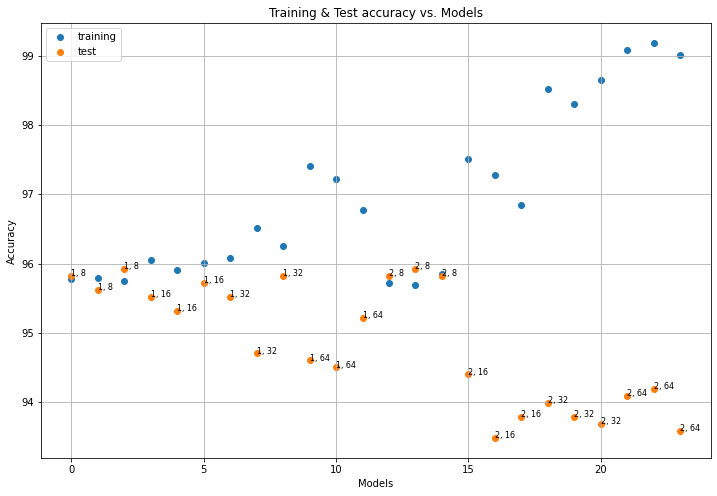

In [163]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(list(results_nn.keys()), train_acc_list, label="training")
plt.scatter(list(results_nn.keys()), test_acc_list, label="test")
plt.title("Training & Test accuracy vs. Models")
plt.legend()
plt.xlabel('Models')
plt.ylabel('Accuracy')
for i in (list(results_nn.keys())):
    ax.text(i, test_acc_list[i], str(results_nn[i][0])+', '+str(results_nn[i][1]), size=8)
plt.grid()
plt.show()

In [141]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('layer: ' + str(layer_list[max_index]))
print('size: ' + str(size_list[max_index]))
print('alpha: ' + str(alpha_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

12
layer: 2
size: 8
alpha: 0.0001
Training accuracy: 95.87366%
Test accuracy: 96.02851%


In [208]:
s=time.time()
mlp = MLPClassifier(
                    hidden_layer_sizes = [8,8],
                    alpha = 0.0001,
                    max_iter = 1500,
                    learning_rate = 'invscaling',
                    verbose = True
                )

# Fit model
mlp.fit(trainX_scaled, train_y)
e=time.time()
print(e-s)



Iteration 1, loss = 0.47644245
Iteration 2, loss = 0.40352423
Iteration 3, loss = 0.34743627
Iteration 4, loss = 0.30323125
Iteration 5, loss = 0.26924117
Iteration 6, loss = 0.24257901
Iteration 7, loss = 0.22211819
Iteration 8, loss = 0.20610490
Iteration 9, loss = 0.19443317
Iteration 10, loss = 0.18573359
Iteration 11, loss = 0.17937555
Iteration 12, loss = 0.17471438
Iteration 13, loss = 0.17110119
Iteration 14, loss = 0.16831042
Iteration 15, loss = 0.16590502
Iteration 16, loss = 0.16392089
Iteration 17, loss = 0.16228505
Iteration 18, loss = 0.16078478
Iteration 19, loss = 0.15935562
Iteration 20, loss = 0.15815551
Iteration 21, loss = 0.15702318
Iteration 22, loss = 0.15596318
Iteration 23, loss = 0.15503743
Iteration 24, loss = 0.15407023
Iteration 25, loss = 0.15327590
Iteration 26, loss = 0.15252510
Iteration 27, loss = 0.15176446
Iteration 28, loss = 0.15108525
Iteration 29, loss = 0.15040992
Iteration 30, loss = 0.14981972
Iteration 31, loss = 0.14933496
Iteration 32, los

NameError: name 'mlf' is not defined

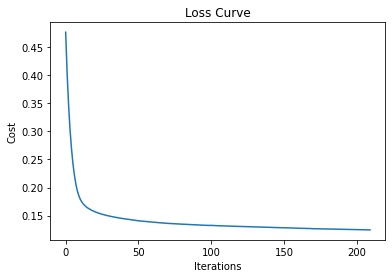

In [209]:
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

epoch:  0
Iteration 1, loss = 1.06521870
Iteration 2, loss = 1.06794431
Iteration 3, loss = 1.06750149
Iteration 4, loss = 1.03260481
Iteration 5, loss = 1.02991684
Iteration 6, loss = 1.02083596
Iteration 7, loss = 1.00133071
Iteration 8, loss = 0.95091405
Iteration 9, loss = 0.97749444
Iteration 10, loss = 1.00765133
Iteration 11, loss = 0.97126447
Iteration 12, loss = 0.93586895
Iteration 13, loss = 0.95397127
Iteration 14, loss = 0.93983608
Iteration 15, loss = 0.90462868
Iteration 16, loss = 0.91760889
Iteration 17, loss = 0.88447655
Iteration 18, loss = 0.90204426
Iteration 19, loss = 0.88027963
Iteration 20, loss = 0.86981155
Iteration 21, loss = 0.83807206
Iteration 22, loss = 0.85615957
Iteration 23, loss = 0.84555937
Iteration 24, loss = 0.85366779
Iteration 25, loss = 0.86328937
Iteration 26, loss = 0.84222230
Iteration 27, loss = 0.83357971
Iteration 28, loss = 0.80044186
Iteration 29, loss = 0.80661464
Iteration 30, loss = 0.81545726
Iteration 31, loss = 0.82336899
epoch: 

Iteration 276, loss = 0.22728305
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 277, loss = 0.22821309
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 278, loss = 0.16017393
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 279, loss = 0.18947487
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
epoch:  9
Iteration 280, loss = 0.17264529
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 281, loss = 0.12520931
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 282, loss = 0.15339432
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 283, loss = 0.22230472
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iterat

Iteration 396, loss = 0.18307214
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 397, loss = 0.16968903
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 398, loss = 0.18118842
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 399, loss = 0.21382030
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 400, loss = 0.16397830
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 401, loss = 0.11594246
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 402, loss = 0.16873934
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 403, loss = 0.19307645
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
epoch:  13
Itera

Iteration 537, loss = 0.11163202
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 538, loss = 0.11700787
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 539, loss = 0.10182330
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 540, loss = 0.12873650
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 541, loss = 0.12607091
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 542, loss = 0.10943872
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 543, loss = 0.17806356
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 544, loss = 0.15768216
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 545, l

Iteration 678, loss = 0.10361862
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 679, loss = 0.18520352
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 680, loss = 0.26167580
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 681, loss = 0.12592971
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 682, loss = 0.16518367
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
epoch:  22
Iteration 683, loss = 0.18668604
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 684, loss = 0.15313216
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 685, loss = 0.11089707
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Itera

epoch:  24
Iteration 745, loss = 0.20899308
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 746, loss = 0.16283802
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 747, loss = 0.16926090
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 748, loss = 0.15531062
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 749, loss = 0.06775863
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 750, loss = 0.12486807
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 751, loss = 0.07860780
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 752, loss = 0.14636157
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Itera

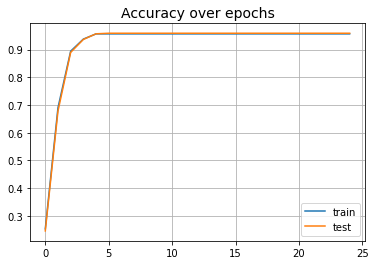

In [149]:
mlp = MLPClassifier(
                    hidden_layer_sizes = [8,8],
                    alpha = 0.0001,
                    max_iter = 10,
                    learning_rate = 'invscaling',
                    verbose = True
                )

# Fit model
#mlp_clf.fit(trainX_scaled, train_y)

""" Home-made mini-batch learning
    -> not to be used in out-of-core setting!
"""
N_TRAIN_SAMPLES = trainX_scaled.shape[0]
N_EPOCHS = 25
N_BATCH = 128
N_CLASSES = np.unique(train_y)

scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    print('epoch: ', epoch)
    # SHUFFLING
    random_perm = np.random.permutation(trainX_scaled.shape[0])
    mini_batch_index = 0
    while True:
        # MINI-BATCH
        indices = random_perm[mini_batch_index:mini_batch_index + N_BATCH]
        mlp.partial_fit(trainX_scaled[indices], train_y[indices], classes=N_CLASSES)
        mini_batch_index += N_BATCH

        if mini_batch_index >= N_TRAIN_SAMPLES:
            break

    # SCORE TRAIN
    scores_train.append(mlp.score(trainX_scaled, train_y))

    # SCORE TEST
    scores_test.append(mlp.score(testX_scaled, test_y))

    epoch += 1



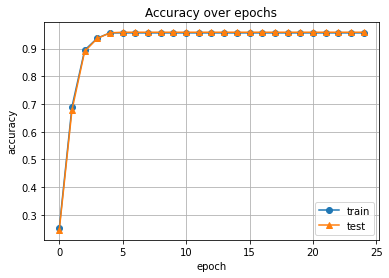

In [152]:
""" Plot """
#fig, ax = plt.subplots(2, sharex=True, sharey=True)
plt.plot(range(N_EPOCHS), scores_train, 'o-',label='train')
plt.plot(range(N_EPOCHS), scores_test, '^-',label='test')
plt.title("Accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [153]:
scores_train[-1], scores_test[-1]

(0.956953642384106, 0.9592668024439919)

/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



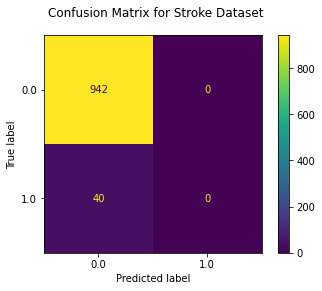

In [154]:
fig = plot_confusion_matrix(mlp, testX_scaled, test_y, display_labels=mlp.classes_)
fig.figure_.suptitle("Confusion Matrix for Stroke Dataset")
plt.show()

# Gradient Boosting
Boosting is a method of converting weak learners into strong learners. In boosting, each new tree is a fit on a modified version of the original data set. It strongly relies on the prediction that the next model will reduce prediction errors when blended with previous ones. The main idea is to establish target outcomes for this upcoming model to minimize errors.

Gradient Boosting trains many models in a gradual, additive and sequential manner. The term gradient boosting emerged because every case’s target outcomes are based on the gradient’s error with regards to the predictions. Every model reduces prediction errors by taking a step in the correct direction.

In [180]:
from sklearn.ensemble import GradientBoostingClassifier

In [181]:
# --- Applying Gradient Boosting ---

GBclassifier = GradientBoostingClassifier(random_state=1, n_estimators=100, max_leaf_nodes=3, 
                                          loss='exponential', 
                                          min_samples_leaf=20)

GBclassifier.fit(train_x, train_y)
y_pred_GB = GBclassifier.predict(test_x)

# --- Gradient Boosting Accuracy ---
GBAcc = accuracy_score(y_pred_GB, test_y)
print('.:. Gradient Boosting Accuracy:'+'\033[1m {:.2f}%'.format(GBAcc*100)+' .:.')

.:. Gradient Boosting Accuracy: 95.93% .:.


In [182]:
def evaluate_gbc(train_x, train_y, test_x, test_y, hyperparameters_dic, results_gbc):
    
    lrs = hyperparameters_dic['lrs']
    estimators = hyperparameters_dic['estimators']
    
    i = len(list(results_gbc.keys()))
    
    n_models = len(lrs)*len(estimators)
    
    for lr in lrs:
        for n in estimators:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_gbc.keys()):
                if lr == results_gbc[r_i][0]:
                    if n == results_gbc[r_i][1]:
                        continue
                        

            results_gbc[i] = []

            model = GradientBoostingClassifier(learning_rate = lr, n_estimators=n)

            model.fit(train_x, train_y)

            train_accuracy = model.score(train_x, train_y)
            test_accuracy = model.score(test_x, test_y)

            results_gbc[i].append(lr)
            results_gbc[i].append(n)
            results_gbc[i].append(train_accuracy)
            results_gbc[i].append(test_accuracy)

            i += 1

    return results_gbc

In [183]:
lrs = [0.1, 1e-2, 1e-3, 1e-4, 1e-5]
#alphas = [1e-2, 1e-3, 1e-4, 1e-5, 5e-5, 1e-6]
estimators = [100, 200, 300, 500, 800, 1000]

hyperparameters_dic = {'lrs': lrs, "estimators":estimators}

results_gbc = evaluate_gbc(train_x, train_y, test_x, test_y, hyperparameters_dic, {})

Training model 1 of 30...
Training model 2 of 30...
Training model 3 of 30...
Training model 4 of 30...
Training model 5 of 30...
Training model 6 of 30...
Training model 7 of 30...
Training model 8 of 30...
Training model 9 of 30...
Training model 10 of 30...
Training model 11 of 30...
Training model 12 of 30...
Training model 13 of 30...
Training model 14 of 30...
Training model 15 of 30...
Training model 16 of 30...
Training model 17 of 30...
Training model 18 of 30...
Training model 19 of 30...
Training model 20 of 30...
Training model 21 of 30...
Training model 22 of 30...
Training model 23 of 30...
Training model 24 of 30...
Training model 25 of 30...
Training model 26 of 30...
Training model 27 of 30...
Training model 28 of 30...
Training model 29 of 30...
Training model 30 of 30...


In [184]:
for key in results_gbc.keys():
    print('lrs: ' + str(results_gbc[key][0]))
    print('# weak leaners: ' + str(results_gbc[key][1]))
    print('Training accuracy: ' + str(results_gbc[key][2]))
    print('Test accuracy: ' + str(results_gbc[key][3]))
    print()

lrs: 0.1
# weak leaners: 100
Training accuracy: 0.9643402954661233
Test accuracy: 0.9562118126272913

lrs: 0.1
# weak leaners: 200
Training accuracy: 0.9732552215995924
Test accuracy: 0.9531568228105907

lrs: 0.1
# weak leaners: 300
Training accuracy: 0.978858889454916
Test accuracy: 0.9531568228105907

lrs: 0.1
# weak leaners: 500
Training accuracy: 0.9893020886398369
Test accuracy: 0.9562118126272913

lrs: 0.1
# weak leaners: 800
Training accuracy: 0.9979623025980642
Test accuracy: 0.9521384928716904

lrs: 0.1
# weak leaners: 1000
Training accuracy: 0.999745287824758
Test accuracy: 0.9501018329938901

lrs: 0.01
# weak leaners: 100
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

lrs: 0.01
# weak leaners: 200
Training accuracy: 0.9577177789098319
Test accuracy: 0.9582484725050916

lrs: 0.01
# weak leaners: 300
Training accuracy: 0.9592460519612838
Test accuracy: 0.9562118126272913

lrs: 0.01
# weak leaners: 500
Training accuracy: 0.9602649006622517
Test accuracy

In [185]:
save_results(results_gbc, 'results_gbc')
results_gbc = load_results('results_gbc.json')

In [186]:
lr_list = [results_gbc[i][0] for i in list(results_gbc.keys())]
n_list = [results_gbc[i][1]*100 for i in list(results_gbc.keys())]
train_acc_list = [results_gbc[i][2]*100 for i in list(results_gbc.keys())]
test_acc_list = [results_gbc[i][3]*100 for i in list(results_gbc.keys())]

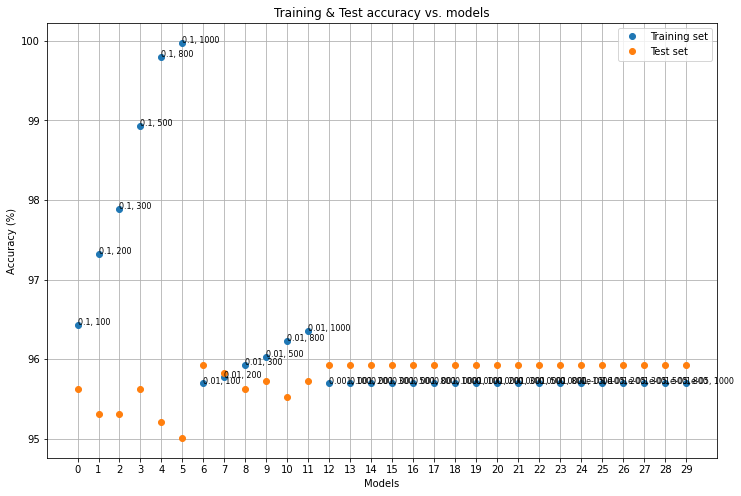

In [187]:
fig, ax = plt.subplots(figsize=(12,8))
lr_list = [results_gbc[i][0] for i in list(results_gbc.keys())]
n_list = [results_gbc[i][1] for i in list(results_gbc.keys())]
train_acc_list = [results_gbc[i][2]*100 for i in list(results_gbc.keys())]
test_acc_list = [results_gbc[i][3]*100 for i in list(results_gbc.keys())]

#alpha_list, train_acc_list, test_acc_list = zip(*sorted(zip(alpha_list, train_acc_list, test_acc_list)))

plt.plot(list(results_gbc.keys()), train_acc_list, 'o', label='Training set')
plt.plot(list(results_gbc.keys()), test_acc_list, 'o', label='Test set')
plt.title("Training & Test accuracy vs. models")
plt.legend()
plt.xlabel("Models")
plt.ylabel('Accuracy (%)')
for i in (list(results_gbc.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_gbc[i][0])+', '+str(results_gbc[i][1]), size=8)
plt.grid()
plt.show()

In [188]:
max_index = np.argmax(test_acc_list)

print(max_index)
print('lr: ' + str(lr_list[max_index]))
print('n_estimator: ' + str(n_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

6
lr: 0.01
n_estimator: 100
Training accuracy: 95.69536%
Test accuracy: 95.92668%


In [189]:
s = time.time()
gbc_clf = GradientBoostingClassifier(learning_rate = 0.01, n_estimators=100)
gbc_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

0.2619168758392334


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



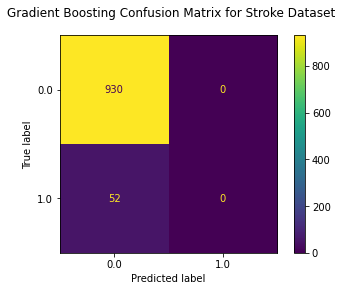

In [65]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(gbc_clf, test_x, test_y, display_labels=gbc_clf.classes_)
fig.figure_.suptitle("Gradient Boosting Confusion Matrix for Stroke Dataset")
plt.show()

# SVM
Support Vector Machine (SVM) is one of the most popular Supervised Learning algorithms, which is used for Classification as well as Regression problems.

The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future. This best decision boundary is called a hyperplane.

SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors, and hence algorithm is termed as Support Vector Machine.

In [190]:
# --- Applying SVM ---
from sklearn.svm import SVC
SVMclassifier = SVC(kernel='linear', max_iter=1000, C=10, probability=True)
SVMclassifier.fit(train_x, train_y)

y_pred_SVM = SVMclassifier.predict(test_x)

# --- SVM Accuracy ---
SVMAcc = accuracy_score(y_pred_SVM, test_y)
print('.:. Support Vector Machine Accuracy:'+'\033[1m {:.2f}%'.format(SVMAcc*100)+' .:.')

.:. Support Vector Machine Accuracy: 85.03% .:.


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



In [191]:
# --- Applying SVM ---
from sklearn.svm import SVC
SVMclassifier = SVC(kernel='linear', C=10)
SVMclassifier.fit(train_x, train_y)

y_pred_SVM = SVMclassifier.predict(test_x)

# --- SVM Accuracy ---
SVMAcc = accuracy_score(y_pred_SVM, test_y)
print('.:. Support Vector Machine Accuracy:'+'\033[1m {:.2f}%'.format(SVMAcc*100)+' .:.')

.:. Support Vector Machine Accuracy: 95.93% .:.


In [192]:
def evaluate_svm(train_x, train_y, test_x, test_y, hyperparameters_dic, results_svm):
    
    cs = hyperparameters_dic['cs']
    kernels = hyperparameters_dic['kernels']
    
    i = len(list(results_svm.keys()))
    
    n_models = len(cs)*len(kernels)
    
    for kernel in kernels:
        for c in cs:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_svm.keys()):
                if c == results_svm[r_i][0]:
                    if kernel == results_svm[r_i][1]:
                        continue

            results_svm[i] = []

            svc_model = SVC(C = c, kernel=kernel)

            svc_model.fit(train_x, train_y)

            train_accuracy = svc_model.score(train_x, train_y)
            test_accuracy = svc_model.score(test_x, test_y)

            results_svm[i].append(c)
            results_svm[i].append(kernel)
            results_svm[i].append(train_accuracy)
            results_svm[i].append(test_accuracy)

            i += 1

    return results_svm

In [193]:
cs = [1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 100, 500, 1000, 10000]
kernels = ['linear', 'rbf']

hyperparameters_dic = {'cs': cs, 'kernels': kernels}

results_svm = evaluate_svm(train_x, train_y, test_x, test_y, hyperparameters_dic, {})

Training model 1 of 20...
Training model 2 of 20...
Training model 3 of 20...
Training model 4 of 20...
Training model 5 of 20...
Training model 6 of 20...
Training model 7 of 20...
Training model 8 of 20...
Training model 9 of 20...
Training model 10 of 20...
Training model 11 of 20...
Training model 12 of 20...
Training model 13 of 20...
Training model 14 of 20...
Training model 15 of 20...
Training model 16 of 20...
Training model 17 of 20...
Training model 18 of 20...
Training model 19 of 20...
Training model 20 of 20...


In [194]:

for key in results_svm.keys():
    print('Cs ' + str(results_svm[key][0]))
    print('Kernel: ' + str(results_svm[key][1]))
    print('Training accuracy: ' + str(results_svm[key][2]))
    print('Test accuracy: ' + str(results_svm[key][3]))
    print()

Cs 1e-05
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 0.0001
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 0.001
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 0.01
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 0.1
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 1
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 100
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 500
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 1000
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 10000
Kernel: linear
Training accuracy: 0.956953642384106
Test accuracy: 0.9592668024439919

Cs 1e-05
Kernel: rbf
Training accuracy: 0.956953642

In [195]:
save_results(results_svm, 'results_svm')

In [196]:
results_svm

{0: [1e-05, 'linear', 0.956953642384106, 0.9592668024439919],
 1: [0.0001, 'linear', 0.956953642384106, 0.9592668024439919],
 2: [0.001, 'linear', 0.956953642384106, 0.9592668024439919],
 3: [0.01, 'linear', 0.956953642384106, 0.9592668024439919],
 4: [0.1, 'linear', 0.956953642384106, 0.9592668024439919],
 5: [1, 'linear', 0.956953642384106, 0.9592668024439919],
 6: [100, 'linear', 0.956953642384106, 0.9592668024439919],
 7: [500, 'linear', 0.956953642384106, 0.9592668024439919],
 8: [1000, 'linear', 0.956953642384106, 0.9592668024439919],
 9: [10000, 'linear', 0.956953642384106, 0.9592668024439919],
 10: [1e-05, 'rbf', 0.956953642384106, 0.9592668024439919],
 11: [0.0001, 'rbf', 0.956953642384106, 0.9592668024439919],
 12: [0.001, 'rbf', 0.956953642384106, 0.9592668024439919],
 13: [0.01, 'rbf', 0.956953642384106, 0.9592668024439919],
 14: [0.1, 'rbf', 0.956953642384106, 0.9592668024439919],
 15: [1, 'rbf', 0.956953642384106, 0.9592668024439919],
 16: [100, 'rbf', 0.956953642384106, 

In [197]:
save_results(results_svm, 'results_svm')

In [198]:
results_svm = load_results('results_svm.json')

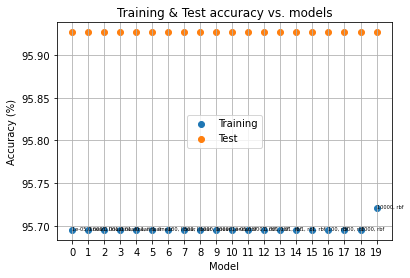

In [199]:
c_list = [results_svm[i][0] for i in list(results_svm.keys())]
kernel_list = [results_svm[i][1] for i in list(results_svm.keys())]
train_acc_list = [results_svm[i][2]*100 for i in list(results_svm.keys())]
test_acc_list = [results_svm[i][3]*100 for i in list(results_svm.keys())]

c_list, train_acc_list, test_acc_list = zip(*sorted(zip(c_list, train_acc_list, test_acc_list)))

fig, ax = plt.subplots()
plt.scatter(list(results_svm.keys()), train_acc_list, label='Training')
plt.scatter(list(results_svm.keys()), test_acc_list, label='Test')
plt.legend(loc='center')
plt.title("Training & Test accuracy vs. models")
plt.xlabel('Model')
plt.grid()
plt.ylabel('Accuracy (%)')
for i in (list(results_svm.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_svm[i][0])+', '+results_svm[i][1], size=5)
plt.show()


In [200]:
max_index = np.argmax(test_acc_list)

print('C: ' + str(c_list[max_index]))
print('Kernel: ' + str(kernel_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

C: 1e-05
Kernel: linear
Training accuracy: 95.69536%
Test accuracy: 95.92668%


In [ ]:
# 这里选个中间的c 0.1

In [202]:
s = time.time()
svm_clf =SVC(C = 0.1, kernel='linear')

svm_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

16.26889729499817


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



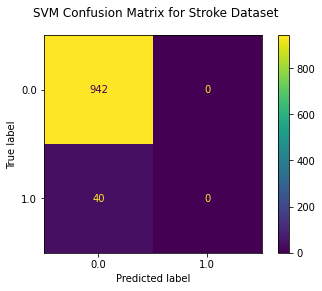

In [210]:
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(svm_clf, test_x, test_y, display_labels=svm_clf.classes_)
fig.figure_.suptitle("SVM Confusion Matrix for Stroke Dataset")
plt.show()

# KNN

The k-nearest neighbors (KNN) algorithm is a data classification method for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to.

The k-nearest neighbor algorithm is a type of supervised machine learning algorithm used to solve classification and regression problems.

It's called a lazy learning algorithm or lazy learner because it doesn't perform any training when you supply the training data. Instead, it just stores the data during the training time and doesn't perform any calculations. It doesn't build a model until a query is performed on the dataset. This makes KNN ideal for data mining..

In [203]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy: 0.9562118126272913


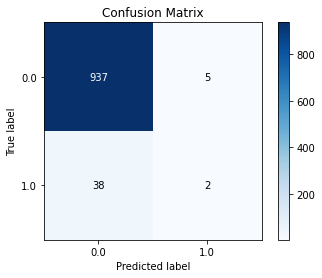

In [204]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(train_x, train_y)
y_pred_knn = knn.predict(test_x)
y_pred_prob_knn = knn.predict_proba(test_x)[:, 1]

skplt.metrics.plot_confusion_matrix(test_y, y_pred_knn);
print('Accuracy:', accuracy_score(test_y, y_pred_knn))

In [77]:
def evaluate_knn(train_x, train_y, test_x, test_y, hyperparameters_dic, results_knn):
    
    neighbors_list = hyperparameters_dic['neighbors_list']
    weights_list = hyperparameters_dic['weights_list']
    
    i = len(list(results_knn.keys()))
    
    n_models = len(neighbors_list)*len(weights_list)
    
    for weights in weights_list:
        for neighbors in neighbors_list:
            
            print('Training model {} of {}...'.format(i+1, n_models))
            
            for r_i in list(results_knn.keys()):
                if neighbors == results_knn[r_i][0]:
                    if weights == results_knn[r_i][1]:
                        continue
            
            results_knn[i] = []
            
            model = KNeighborsClassifier(n_neighbors=neighbors, weights=weights)
            
            model.fit(train_x, train_y)
            
            train_accuracy = model.score(train_x, train_y)
            test_accuracy = model.score(test_x, test_y)
            
            results_knn[i].append(neighbors)
            results_knn[i].append(weights)
            results_knn[i].append(train_accuracy)
            results_knn[i].append(test_accuracy)
            
            i += 1
            
    return results_knn

In [95]:
neighbors_list = list(range(2, 21))
print(neighbors_list)
weights_list = ['uniform', 'distance']

hyperparameter_dic = {'neighbors_list': neighbors_list, 'weights_list': weights_list}

results_knn = evaluate_knn(train_x, train_y, test_x, test_y, hyperparameter_dic, {})

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Training model 1 of 38...
Training model 2 of 38...
Training model 3 of 38...
Training model 4 of 38...
Training model 5 of 38...
Training model 6 of 38...
Training model 7 of 38...
Training model 8 of 38...
Training model 9 of 38...
Training model 10 of 38...
Training model 11 of 38...
Training model 12 of 38...
Training model 13 of 38...
Training model 14 of 38...
Training model 15 of 38...
Training model 16 of 38...
Training model 17 of 38...
Training model 18 of 38...
Training model 19 of 38...
Training model 20 of 38...
Training model 21 of 38...
Training model 22 of 38...
Training model 23 of 38...
Training model 24 of 38...
Training model 25 of 38...
Training model 26 of 38...
Training model 27 of 38...
Training model 28 of 38...
Training model 29 of 38...
Training model 30 of 38...
Training model 31 of 38...
Training model 32 of 38...
Training model 33 of 38...
Training model 34 of 38...
Training model 35 of 3

In [96]:
for key in results_knn.keys():
    print('Number nerighbors: ' + str(results_knn[key][0]))
    print('Weighting: ' + str(results_knn[key][1]))
    print('Training accuracy: ' + str(results_knn[key][2]))
    print('Test accuracy: ' + str(results_knn[key][3]))
    print()

Number nerighbors: 2
Weighting: uniform
Training accuracy: 0.9617931737137035
Test accuracy: 0.9562118126272913

Number nerighbors: 3
Weighting: uniform
Training accuracy: 0.9610290371879776
Test accuracy: 0.9531568228105907

Number nerighbors: 4
Weighting: uniform
Training accuracy: 0.9579724910850739
Test accuracy: 0.9582484725050916

Number nerighbors: 5
Weighting: uniform
Training accuracy: 0.955934793683138
Test accuracy: 0.9562118126272913

Number nerighbors: 6
Weighting: uniform
Training accuracy: 0.956698930208864
Test accuracy: 0.9592668024439919

Number nerighbors: 7
Weighting: uniform
Training accuracy: 0.9554253693326541
Test accuracy: 0.9572301425661914

Number nerighbors: 8
Weighting: uniform
Training accuracy: 0.95618950585838
Test accuracy: 0.9592668024439919

Number nerighbors: 9
Weighting: uniform
Training accuracy: 0.956444218033622
Test accuracy: 0.9592668024439919

Number nerighbors: 10
Weighting: uniform
Training accuracy: 0.956444218033622
Test accuracy: 0.959266

In [97]:
save_results(results_knn, 'results_knn')

In [98]:
results_knn = load_results('results_knn.json')

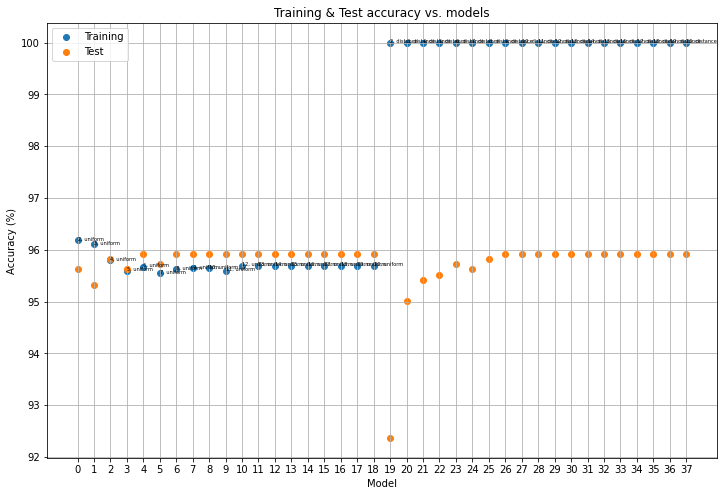

In [102]:
neighbors_list = [results_knn[i][0] for i in list(results_knn.keys())]
weights_list = [results_knn[i][1] for i in list(results_knn.keys())]
train_acc_list = [results_knn[i][2]*100 for i in list(results_knn.keys())]
test_acc_list = [results_knn[i][3]*100 for i in list(results_knn.keys())]

#c_list, train_acc_list, test_acc_list = zip(*sorted(zip(c_list, train_acc_list, test_acc_list)))

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(list(results_knn.keys()), train_acc_list, label='Training')
plt.scatter(list(results_knn.keys()), test_acc_list, label='Test')
plt.legend()
plt.title("Training & Test accuracy vs. models")
plt.xlabel('Model')
plt.grid()
plt.ylabel('Accuracy (%)')
for i in (list(results_knn.keys())):
    ax.text(i, train_acc_list[int(i)], str(results_knn[i][0])+', '+results_knn[i][1], size=5)
plt.show()


In [105]:
max_index = np.argmax(test_acc_list)
print(max_index)
print('Number of Neighbors: ' + str(neighbors_list[max_index]))
print('Weighting Methond: ' + str(weights_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

4
Number of Neighbors: 6
Weighting Methond: uniform
Training accuracy: 95.66989%
Test accuracy: 95.92668%


In [205]:
s = time.time()
knn_clf = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn_clf.fit(train_x, train_y)
e = time.time()
print(e-s)

0.004612922668457031


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



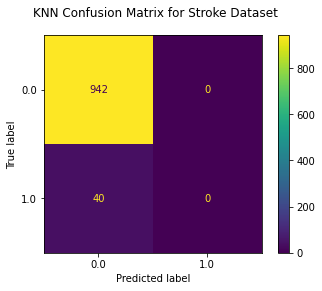

In [108]:
fig = plot_confusion_matrix(knn_clf, test_x, test_y, display_labels=knn_clf.classes_)
fig.figure_.suptitle("KNN Confusion Matrix for Stroke Dataset")
plt.show()

In [111]:
max_index = 9
print(max_index)
print('Number of Neighbors: ' + str(neighbors_list[max_index]))
print('Weighting Methond: ' + str(weights_list[max_index]))
print('Training accuracy: ' + str(round(train_acc_list[max_index], 5)) + '%')
print('Test accuracy: ' + str(round(test_acc_list[max_index], 5)) + '%')

9
Number of Neighbors: 11
Weighting Methond: uniform
Training accuracy: 95.59348%
Test accuracy: 95.92668%


/home/char/miniconda3/envs/ai_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



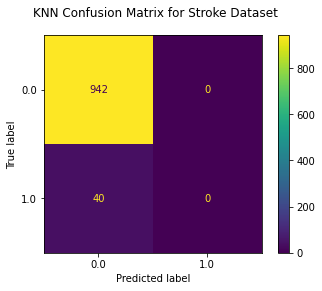

In [112]:
knn_clf = KNeighborsClassifier(n_neighbors=11, weights='uniform')
knn_clf.fit(train_x, train_y)
fig = plot_confusion_matrix(knn_clf, test_x, test_y, display_labels=knn_clf.classes_)
fig.figure_.suptitle("KNN Confusion Matrix for Stroke Dataset")
plt.show()